# RSI momentum trading strategy example

- This is a backtest example notebook
    - Check high trading fee options for ETH-MATIC-USDC

# Set up

Set up Trading Strategy data client.

In [96]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client

client = Client.create_jupyter_client()


# Render for Github web viewer
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)
# etup_charting_and_output(width=1500, height=1000)

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/datalore/.tradingstrategy


# Load data

We use Binance data so we get a longer period of data.

In [97]:
import datetime
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.chain import ChainId
from tradeexecutor.utils.binance import create_binance_universe

strategy_universe = create_binance_universe(
    ["BTCUSDT", "ETHUSDT"],   # Binance internal tickers later mapped to Trading strategy DEXPair metadata class
    candle_time_bucket=TimeBucket.d1,
    stop_loss_time_bucket=TimeBucket.h1,
    start_at=datetime.datetime(2019, 1, 1),  # Backtest for 5 years data
    end_at=datetime.datetime(2024, 3, 15),
    include_lending=False
)

# List of pair descriptions we used to look up pair metadata
our_pairs = [
    (ChainId.centralised_exchange, "binance", "BTC", "USDT"),
    (ChainId.centralised_exchange, "binance", "ETH", "USDT"),
]


100%|██████████| 2/2 [00:00<00:00, 39.94it/s, pair=ETHUSDT, total_size (MBytes)=3.83]


# Show loaded trading universe

Display generic troubleshooting information about the loaded data.

In [98]:
from tradingstrategy.chain import ChainId

pairs = strategy_universe.data_universe.pairs  # Trading pairs metadata
candles = strategy_universe.data_universe.candles  # Candles for all trading pairs

print(f"Loaded {candles.get_candle_count():,} candles.")

for pair in pairs.iterate_pairs():
    pair_candles = candles.get_candles_by_pair(pair)
    first_close = pair_candles.iloc[0]["close"]
    first_close_at = pair_candles.index[0]
    print(f"Pair {pair} first close price {first_close} at {first_close_at}")

Loaded 3,802 candles.
Pair <Pair #1 BTC - USDT at exchange binance> first close price 3797.14 at 2019-01-01 00:00:00
Pair <Pair #2 ETH - USDT at exchange binance> first close price 139.1 at 2019-01-01 00:00:00


# Indicators

- Prepare indicators needed for the grid

In [99]:
import pandas_ta
import pandas as pd

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.utils.groupeduniverse import resample_price_series


def calculate_shifted_rsi(pair_close_price_series: pd.Series, length: int, upsample: TimeBucket, shift: int):
    resampled_close = resample_price_series(pair_close_price_series, upsample.to_pandas_timedelta(), shift=shift)
    return pandas_ta.rsi(resampled_close, length=length)


def calculate_shifted_eth_btc(strategy_universe: TradingStrategyUniverse, upsample: TimeBucket, shift: int):
    """ETH/BTC price series."""
    eth = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc = strategy_universe.get_pair_by_human_description(our_pairs[1])
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    resampled_btc = resample_price_series(btc_price, upsample.to_pandas_timedelta(), shift=shift)
    resampled_eth = resample_price_series(eth_price, upsample.to_pandas_timedelta(), shift=shift)
    series = resampled_btc / resampled_eth  # Divide two series
    return series


def calculate_eth_btc(strategy_universe: TradingStrategyUniverse):
    eth = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc = strategy_universe.get_pair_by_human_description(our_pairs[1])    
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    series = eth_price["close"] / btc_price["close"]  # Divide two series
    return series

def calculate_eth_btc_rsi(strategy_universe: TradingStrategyUniverse, length: int):
    weth_usdc = strategy_universe.get_pair_by_human_description((ChainId.ethereum, "test-dex", "WETH", "USDC"))
    wbtc_usdc = strategy_universe.get_pair_by_human_description((ChainId.ethereum, "test-dex", "WBTC", "USDC"))
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(wbtc_usdc.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(weth_usdc.internal_id)
    eth_btc = eth_price["close"] / btc_price["close"]
    return pandas_ta.rsi(eth_btc, length=length)

def create_indicators(
    parameters: StrategyParameters,
    indicators: IndicatorSet,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    # Calculate RSI for all pairs
    indicators.add("rsi", calculate_shifted_rsi, {"length": parameters.rsi_bars, "upsample": parameters.upsample, "shift": parameters.shift})
    # Custom: ETC/BTC close price
    indicators.add("eth_btc", calculate_shifted_eth_btc, {"upsample": parameters.upsample, "shift": parameters.shift}, source=IndicatorSource.strategy_universe)
    # Custom: ETC/BTC RSI
    # indicators.add("eth_btc_rsi", calculate_eth_btc_rsi, parameters={"length": parameters.eth_btc_rsi_bars}, source=IndicatorSource.strategy_universe)

# Trading algorithm

In [100]:
import pandas as pd

from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput
from tradeexecutor.strategy.weighting import weight_passthrouh
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.visualisation import PlotKind, PlotShape, PlotLabel
from tradeexecutor.state.trade import TradeExecution


def decide_trades(
    input: StrategyInput,
) -> list[TradeExecution]:

    # Resolve our pair metadata for our two pair strategy
    parameters = input.parameters 
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    shift = parameters.shift
    clock_shift = pd.Timedelta(hours=1) * shift

    # Execute the daily trade cycle when the clock hour 0..24 is correct for our hourly shift
    assert parameters.upsample.to_timedelta() >= parameters.cycle_duration.to_timedelta(), "Upsample period must be longer than cycle period"    
    assert shift <= 0  # Shift -1 = do action 1 hour later

    # Override the trading fee to simulate worse fees and price impact
    if parameters.trading_fee_override is not None:
        input.pricing_model.set_trading_fee_override(parameters.trading_fee_override)    

    # Do the clock shift trick
    if parameters.cycle_duration.to_timedelta() != parameters.upsample.to_timedelta():
        if (input.cycle - 1 + shift) % int(parameters.upsample.to_hours()) != 0:
            return []

    alpha_model = AlphaModel(input.timestamp)
    btc_pair = position_manager.get_trading_pair(our_pairs[0])
    eth_pair = position_manager.get_trading_pair(our_pairs[1])
    position_manager.log("decide_trades() start")

    #
    # Indicators
    #
    # Calculate indicators for each pair.
    #

    # Per-trading pair calcualted data
    current_rsi_values = {}  # RSI yesterday
    previous_rsi_values = {}  # RSI day before yesterday
    current_price = {}  # Close price yesterday
    momentum = {btc_pair: 0, eth_pair: 0}
    eth_btc_rsi_yesterday = None

    for pair in [btc_pair, eth_pair]:        
        current_price[pair] = indicators.get_price(pair)

        current_rsi_values[pair] = indicators.get_indicator_value("rsi", index=-1, pair=pair, clock_shift=clock_shift)
        previous_rsi_values[pair] = indicators.get_indicator_value("rsi", index=-2, pair=pair, clock_shift=clock_shift)

        if shift and input.cycle > 100:
            indicators.get_indicator_value("rsi", index=-1 + shift, pair=pair, clock_shift=clock_shift)

    eth_btc_yesterday = indicators.get_indicator_value("eth_btc", clock_shift=clock_shift)
    eth_btc_rsi_yesterday = indicators.get_indicator_value("eth_btc_rsi", clock_shift=clock_shift)
    if eth_btc_rsi_yesterday is not None:
        eth_momentum = (eth_btc_rsi_yesterday / 100) + 0.5 
        btc_momentum = (1 - (eth_btc_rsi_yesterday / 100)) + 0.5
        momentum[eth_pair] = eth_momentum ** parameters.momentum_exponent
        momentum[btc_pair] = btc_momentum ** parameters.momentum_exponent

    #
    # Trading logic
    #

    for pair in [btc_pair, eth_pair]:

        # Each pair has its own bullish/bearish regime

        price = current_price[pair] 

        # 
        # Regime filter
        #
        # If no indicator data yet, or regime filter disabled,
        # be always bullish
        bullish = True  
        if parameters.regime_filter_ma_length:  # Regime filter is not disabled
            regime_filter_pair = btc_pair if parameters.regime_filter_only_btc else pair
            regime_filter_price = current_price[regime_filter_pair]
            sma = indicators.get_indicator_value("sma", index=-1, pair=regime_filter_pair, clock_shift=clock_shift)
            if sma:
                # We are bearish if close price is beloe SMA
                bullish = regime_filter_price > sma
        
        if bullish:
            rsi_entry = parameters.bullish_rsi_entry
            rsi_exit = parameters.bullish_rsi_exit
        else:
            rsi_entry = parameters.bearish_rsi_entry
            rsi_exit = parameters.bearish_rsi_exit            

        existing_position = position_manager.get_current_position_for_pair(pair)
        pair_open = existing_position is not None
        pair_momentum = momentum.get(pair, 0)
        signal_strength = max(pair_momentum, 0.1)  # Singal strength must be positive, as we do long-only
        if pd.isna(signal_strength):
            signal_strength = 0
        alpha_model.set_signal(pair, 0)

        if pair_open:
            # We have existing open position for this pair,
            # keep it open by default unless we get a trigger condition below
            position_manager.log(f"Pair {pair} already open")
            alpha_model.set_signal(pair, signal_strength, stop_loss=parameters.stop_loss)

        if current_rsi_values[pair] and previous_rsi_values[pair]:

            # Check for RSI crossing our threshold values in this cycle, compared to the previous cycle
            if rsi_entry:
                rsi_cross_above = current_rsi_values[pair] >= rsi_entry and previous_rsi_values[pair] < rsi_entry
            else:
                # bearish_rsi_entry = None -> don't trade in bear market
                rsi_cross_above = False

            rsi_cross_below = current_rsi_values[pair] < rsi_exit and previous_rsi_values[pair] > rsi_exit

            if not pair_open:
                # Check for opening a position if no position is open
                if rsi_cross_above:
                    position_manager.log(f"Pair {pair} crossed above")
                    alpha_model.set_signal(pair, signal_strength, stop_loss=parameters.stop_loss)
            else:
                # We have open position, check for the close condition
                if rsi_cross_below:
                    position_manager.log(f"Pair {pair} crossed below")
                    alpha_model.set_signal(pair, 0)

    # Enable trailing stop loss if we have reached the activation level
    if parameters.trailing_stop_loss_activation_level is not None and parameters.trailing_stop_loss is not None:
       for p in state.portfolio.open_positions.values():
           if p.trailing_stop_loss_pct is None:
               if current_price[p.pair] >= p.get_opening_price() * parameters.trailing_stop_loss_activation_level:
                   p.trailing_stop_loss_pct = parameters.trailing_stop_loss

    # Use alpha model and construct a portfolio of two assets
    alpha_model.select_top_signals(2)
    alpha_model.assign_weights(weight_passthrouh)
    alpha_model.normalise_weights()
    alpha_model.update_old_weights(state.portfolio)
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation
    alpha_model.calculate_target_positions(position_manager, portfolio_target_value)
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=parameters.rebalance_threshold * portfolio.get_total_equity(),
    )

    #
    # Visualisations
    #

    if input.is_visualisation_enabled():

        visualisation = state.visualisation  # Helper class to visualise strategy output

        # BTC RSI daily
        if current_rsi_values[btc_pair]:
            visualisation.plot_indicator(
                timestamp,
                f"RSI BTC",
                PlotKind.technical_indicator_detached,
                current_rsi_values[btc_pair],
                colour="orange",
            )


            # Low (vertical line)
            visualisation.plot_indicator(
                timestamp,
                f"RSI low trigger",
                PlotKind.technical_indicator_overlay_on_detached,
                parameters.rsi_low,
                detached_overlay_name=f"RSI BTC",
                plot_shape=PlotShape.horizontal_vertical,
                colour="red",
                label=PlotLabel.hidden,
            )

            # High (vertical line)
            visualisation.plot_indicator(
                timestamp,
                f"RSI high trigger",
                PlotKind.technical_indicator_overlay_on_detached,
                parameters.rsi_high,
                detached_overlay_name=f"RSI BTC",
                plot_shape=PlotShape.horizontal_vertical,
                colour="red",
                label=PlotLabel.hidden,
            )

        # ETH RSI daily
        if current_rsi_values[eth_pair]:
            visualisation.plot_indicator(
                timestamp,
                f"RSI ETH",
                PlotKind.technical_indicator_overlay_on_detached,
                current_rsi_values[eth_pair],
                colour="blue",
                label=PlotLabel.hidden,
                detached_overlay_name=f"RSI BTC",
            )

        if eth_btc_yesterday is not None:
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC",
                PlotKind.technical_indicator_detached,
                eth_btc_yesterday,
                colour="grey",
            )

        if eth_btc_rsi_yesterday is not None:
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC RSI",
                PlotKind.technical_indicator_detached,
                eth_btc_rsi_yesterday,
                colour="grey",
            )

        state.visualisation.add_calculations(timestamp, alpha_model.to_dict())  # Record alpha model thinking

    position_manager.log(
        f"BTC RSI: {current_rsi_values[btc_pair]}, BTC RSI yesterday: {previous_rsi_values[btc_pair]}",
    )

    return trades

# Strategy indicators

- Set up indicators used to decide trades
- Indicator data will be precalculated and cached between strategy runs 
- The actual calculation is run (if needed) later on `run_backtest_inline()` call

In [101]:
import pandas_ta

from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse


def calculate_shifted_btc_price(strategy_universe: TradingStrategyUniverse, upsample: TimeBucket, shift: int):
    """"BTC price (shifted)

    "For diagnostics.
    """
    btc = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    resampled_btc = resample_price_series(btc_price["close"], upsample.to_pandas_timedelta(), shift=shift)
    return resampled_btc


def calculate_shifted_rsi(pair_close_price_series: pd.Series, length: int, upsample: TimeBucket, shift: int):
    resampled_close = resample_price_series(pair_close_price_series, upsample.to_pandas_timedelta(), shift=shift)
    return pandas_ta.rsi(resampled_close, length=length)


def calculate_shifted_sma(pair_close_price_series: pd.Series, length: int, upsample: TimeBucket, shift: int):
    resampled_close = resample_price_series(pair_close_price_series, upsample.to_pandas_timedelta(), shift=shift)
    return pandas_ta.sma(resampled_close, length=length)


def calculate_shifted_eth_btc(strategy_universe: TradingStrategyUniverse, upsample: TimeBucket, shift: int):
    """ETH/BTC price series."""
    btc = strategy_universe.get_pair_by_human_description(our_pairs[0])
    eth = strategy_universe.get_pair_by_human_description(our_pairs[1])
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    resampled_btc = resample_price_series(btc_price["close"], upsample.to_pandas_timedelta(), shift=shift)
    resampled_eth = resample_price_series(eth_price["close"], upsample.to_pandas_timedelta(), shift=shift)
    series = resampled_eth / resampled_btc
    return series


def calculate_shifted_eth_btc_rsi(strategy_universe: TradingStrategyUniverse, length: int, upsample: TimeBucket, shift: int):
     """ETH/BTC RSI series."""
     etc_btc = calculate_shifted_eth_btc(strategy_universe, upsample, shift)
     return pandas_ta.rsi(etc_btc, length=length)


def create_indicators(
    parameters: StrategyParameters,
    indicators: IndicatorSet,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators.add("rsi", calculate_shifted_rsi, {"length": parameters.rsi_bars, "upsample": parameters.upsample, "shift": parameters.shift})
    indicators.add("sma", calculate_shifted_sma, {"length": parameters.regime_filter_ma_length, "upsample": parameters.upsample, "shift": parameters.shift})
    indicators.add("eth_btc", calculate_shifted_eth_btc, {"upsample": parameters.upsample, "shift": parameters.shift}, source=IndicatorSource.strategy_universe)
    indicators.add("eth_btc_rsi", calculate_shifted_eth_btc_rsi, {"upsample": parameters.upsample, "shift": parameters.shift, "length": parameters.eth_btc_rsi_bars}, source=IndicatorSource.strategy_universe)
    indicators.add("resampled_btc", calculate_shifted_btc_price, {"upsample": parameters.upsample, "shift": parameters.shift}, source=IndicatorSource.strategy_universe)


# Parameters

- Set up strategy parameters for this backtest run

In [102]:
class HighFeeStopLossStrategyParameters:
    cycle_duration = CycleDuration.cycle_1d
    rsi_bars = [8, 12, 21, 30]
    eth_btc_rsi_bars = 5
    
    bullish_rsi_entry = [50, 55, 60, 65, 70, 75, 80]
    bullish_rsi_exit = [50, 55, 60, 65, 70, 75, 80]

    bearish_rsi_entry = [50, 55, 60, 65, 67, 70, 75, 80, None]
    bearish_rsi_exit = [50, 54, 60, 65, 67, 70, 75, 80]

    regime_filter_ma_length = [50, 100, 150, 200, None] 
    regime_filter_only_btc = [1, 0]

    allocation = 0.98 
    rebalance_threshold = 0.275
    initial_cash = 10_000 
    #trailing_stop_loss = 0.975
    #trailing_stop_loss_activation_level = 1.06
    #stop_loss = 0.85
    trailing_stop_loss = None
    trailing_stop_loss_activation_level = None
    stop_loss = None
    shift = 0    
    upsample = TimeBucket.d1
    momentum_exponent = 2.5
    trading_fee_override = 0.0030
    

# Grid search

Run the grid search.

In [103]:
import logging
from tradeexecutor.cli.log import setup_notebook_logging
from tradeexecutor.backtest.grid_search import GridCombination, get_grid_search_result_path, perform_grid_search, prepare_grid_combinations

# This is the path where we keep the result files around
storage_folder = get_grid_search_result_path("v42")

# Popular grid search combinations and indicators for them
combinations = prepare_grid_combinations(
    HighFeeStopLossStrategyParameters, 
    storage_folder,
    create_indicators=create_indicators,
    strategy_universe=strategy_universe,
)

indicators = GridCombination.get_all_indicators(combinations)

print(f"We prepared {len(combinations)} grid search combinations with total {len(indicators)} indicators which need to be calculated, stored in {storage_folder.resolve()}")


grid_search_results = perform_grid_search(
    decide_trades,
    strategy_universe,
    combinations,
    trading_strategy_engine_version="0.5",
    multiprocess=True,
)

We prepared 141120 grid search combinations with total 21 indicators which need to be calculated, stored in /home/datalore/.cache/trading-strategy/grid-search/v42
Using indicator cache /home/datalore/.cache/indicators/centralised-exchange_1d_BTC-USDT-ETH-USDT_2019-01-01-2024-03-15
Using grid search cache /home/datalore/.cache/trading-strategy/grid-search/v42, for indicators bearish_rsi_entry, bearish_rsi_exit, bullish_rsi_entry, bullish_rsi_exit, regime_filter_ma_length, regime_filter_only_btc, rsi_bars
All results were cached, grid search skipped


Reading cached search results w/ 30 threads: 100%|██████████| 141120/141120 [03:35<00:00, 655.79it/s]


# Grid search result comparison

In [104]:
# Set Jupyter Notebook output mode parameters
from tradeexecutor.analysis.grid_search import analyse_grid_search_result
from tradeexecutor.analysis.grid_search import visualise_table

# Print extension of our backtest
cached_results = [r for r in grid_search_results if r.cached]
print(f"Grid search results available: {len(grid_search_results)}, of which we got cached {len(cached_results)} in {storage_folder}")

#table = analyse_grid_search_result(grid_search_results)
#table = table.reset_index()
#visualise_table(table)

Grid search results available: 141120, of which we got cached 141120 in /home/datalore/.cache/trading-strategy/grid-search/v42


## Best overall

In [105]:
from tradeexecutor.analysis.grid_search import find_best_grid_search_results, render_grid_search_result_table
from tradeexecutor.visual.grid_search import visualise_single_grid_search_result_benchmark

best_results = find_best_grid_search_results(grid_search_results)
print("By CAGR")
render_grid_search_result_table(best_results.cagr)



By CAGR


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_length 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 50 
 60 
 50 
 55 
 150 
 0 
 8 
 139 
 434 
 75.00% 
 106.86% 
 -61.00% 
 1.490000 
 2.280000 
 2.74% 
 -0.09% 
 
 
 60 
 55 
 100 
 0 
 21 
 51 
 262 
 68.00% 
 104.88% 
 -55.00% 
 1.470000 
 2.200000 
 4.22% 
 0.89% 
 
 
 65 
 50 
 55 
 200 
 1 
 8 
 106 
 374 
 78.00% 
 108.11% 
 -68.00% 
 1.470000 
 2.240000 
 3.88% 
 1.26% 
 
 
 55 
 50 
 55 
 80 
 150 
 1 
 30 
 15 
 199 
 79.00% 
 112.50% 
 -61.00% 
 1.500000 
 2.200000 
 6.69% 
 3.84% 
 
 
 60 
 75 
 100 
 1 
 30 
 24 
 201 
 70.00% 
 109.37% 
 -54.00% 
 1.520000 
 2.240000 
 11.46% 
 9.89% 
 
 
 80 
 100 
 1 
 30 
 17 
 210 
 71.00% 
 121.27% 
 -57.00% 
 1.600000 
 2.350000 
 12.21% 
 4.17% 
 
 
 150 
 0 
 30 
 14 
 267 
 78.00% 
 114.90% 
 -58.00% 
 1.510000 
 2.220000 
 7.06% 
 4.60% 
 
 
 54 
 55 
 80 
 150 
 0 
 30 
 17 
 230 
 80.00% 
 110.72% 
 -65.00% 
 1.460000 
 2.140000 
 3.55% 
 0.43% 
 
 
 65 
 65 
 50 
 200 
 0 
 12 
 51 
 231 
 65.00% 
 109.91% 
 -51.00% 
 1.580000 
 2.510000 
 5.31% 
 1.59% 
 
 
 70 
 55 
 55 
 150 
 0 
 12 
 113 
 411 
 71.00% 
 117.19% 
 -47.00% 
 1.640000 
 2.630000 
 1.72% 
 -1.60% 
 
 
 65 
 50 
 100 
 0 
 12 
 44 
 234 
 69.00% 
 105.57% 
 -55.00% 
 1.470000 
 2.220000 
 6.49% 
 2.85% 
 
 
 150 
 0 
 12 
 43 
 224 
 69.00% 
 112.77% 
 -55.00% 
 1.520000 
 2.310000 
 6.76% 
 0.58% 
 
 
 60 
 50 
 60 
 80 
 100 
 1 
 30 
 15 
 200 
 69.00% 
 123.05% 
 -57.00% 
 1.630000 
 2.400000 
 14.06% 
 6.45% 
 
 
 60 
 70 
 80 
 150 
 0 
 30 
 7 
 91 
 81.00% 
 119.21% 
 -68.00% 
 1.490000 
 2.170000 
 27.03% 
 25.04% 
 
 
 1 
 30 
 8 
 79 
 81.00% 
 122.48% 
 -68.00% 
 1.520000 
 2.240000 
 29.71% 
 31.27% 
 
 
 65 
 50 
 60 
 80 
 100 
 1 
 30 
 14 
 198 
 69.00% 
 131.70% 
 -57.00% 
 1.700000 
 2.510000 
 16.37% 
 7.14% 
 
 
 150 
 1 
 30 
 13 
 233 
 76.00% 
 113.77% 
 -62.00% 
 1.530000 
 2.240000 
 14.52% 
 7.15% 
 
 
 60 
 70 
 80 
 150 
 0 
 30 
 6 
 89 
 81.00% 
 119.94% 
 -68.00% 
 1.490000 
 2.180000 
 31.83% 
 33.01% 
 
 
 1 
 30 
 6 
 73 
 68.00% 
 117.82% 
 -68.00% 
 1.570000 
 2.330000 
 37.46% 
 41.79% 
 
 
 67 
 67 
 50 
 55 
 150 
 0 
 8 
 130 
 381 
 65.00% 
 115.71% 
 -54.00% 
 1.580000 
 2.440000 
 2.81% 
 -1.04%

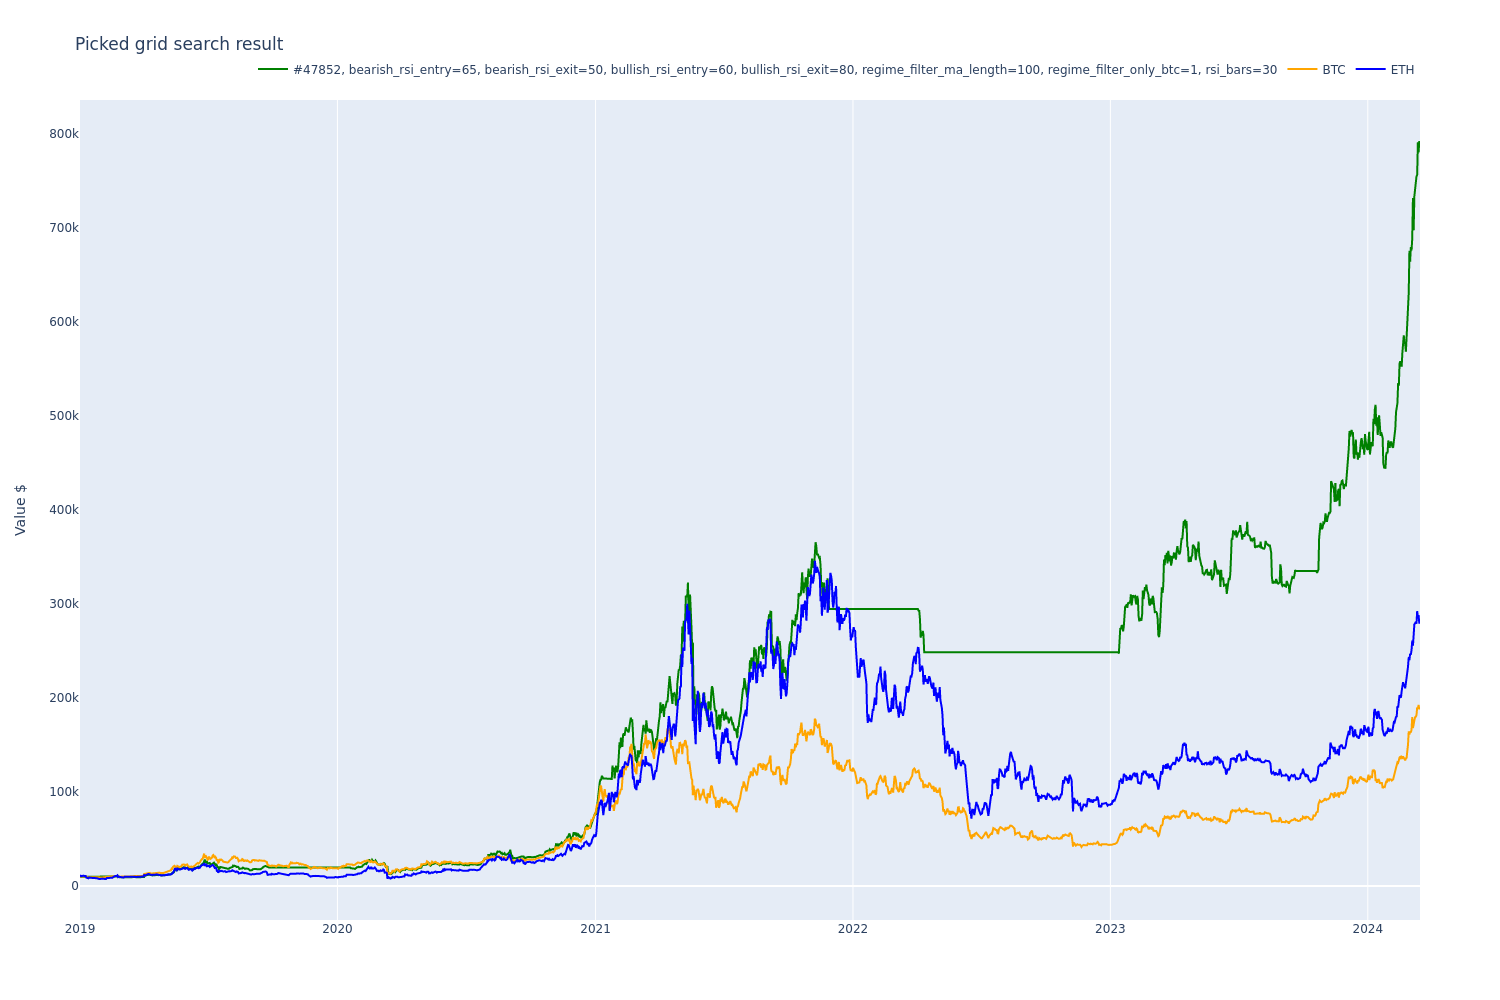

In [106]:
fig = visualise_single_grid_search_result_benchmark(best_results.cagr[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

In [107]:
print("By Sharpe")
render_grid_search_result_table(best_results.sharpe)


By Sharpe


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_length 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 55 
 50 
 60 
 65 
 150 
 1 
 12 
 91 
 345 
 62.00% 
 103.33% 
 -51.00% 
 1.600000 
 2.570000 
 3.48% 
 0.79% 
 
 
 200 
 1 
 12 
 91 
 345 
 62.00% 
 102.44% 
 -51.00% 
 1.590000 
 2.560000 
 3.48% 
 0.79% 
 
 
 70 
 75 
 150 
 1 
 12 
 67 
 259 
 64.00% 
 106.72% 
 -47.00% 
 1.570000 
 2.480000 
 4.87% 
 1.22% 
 
 
 65 
 65 
 50 
 200 
 0 
 12 
 51 
 231 
 65.00% 
 109.91% 
 -51.00% 
 1.580000 
 2.510000 
 5.31% 
 1.59% 
 
 
 67 
 60 
 50 
 200 
 0 
 12 
 59 
 285 
 66.00% 
 114.80% 
 -49.00% 
 1.650000 
 2.610000 
 3.40% 
 0.83% 
 
 
 70 
 55 
 55 
 150 
 0 
 12 
 113 
 411 
 71.00% 
 117.19% 
 -47.00% 
 1.640000 
 2.630000 
 1.72% 
 -1.60% 
 
 
 60 
 50 
 200 
 0 
 12 
 56 
 275 
 67.00% 
 112.07% 
 -49.00% 
 1.610000 
 2.530000 
 3.77% 
 0.16% 
 
 
 60 
 50 
 60 
 65 
 150 
 1 
 12 
 83 
 328 
 60.00% 
 109.76% 
 -48.00% 
 1.680000 
 2.710000 
 3.86% 
 1.09% 
 
 
 200 
 1 
 12 
 84 
 330 
 60.00% 
 108.02% 
 -48.00% 
 1.660000 
 2.680000 
 3.79% 
 1.02% 
 
 
 80 
 100 
 1 
 30 
 15 
 200 
 69.00% 
 123.05% 
 -57.00% 
 1.630000 
 2.400000 
 14.06% 
 6.45% 
 
 
 65 
 55 
 55 
 100 
 0 
 12 
 119 
 430 
 68.00% 
 110.17% 
 -53.00% 
 1.620000 
 2.590000 
 1.32% 
 -1.39% 
 
 
 65 
 50 
 60 
 80 
 100 
 1 
 30 
 14 
 198 
 69.00% 
 131.70% 
 -57.00% 
 1.700000 
 2.510000 
 16.37% 
 7.14% 
 
 
 54 
 50 
 55 
 50 
 1 
 8 
 108 
 299 
 54.00% 
 102.31% 
 -41.00% 
 1.670000 
 2.750000 
 3.49% 
 -0.65% 
 
 
 55 
 50 
 50 
 1 
 8 
 107 
 355 
 57.00% 
 110.11% 
 -37.00% 
 1.690000 
 2.700000 
 2.16% 
 -1.52% 
 
 
 70 
 80 
 65 
 200 
 1 
 8 
 61 
 174 
 30.00% 
 82.43% 
 -34.00% 
 1.770000 
 3.060000 
 4.67% 
 0.55% 
 
 
 67 
 67 
 80 
 65 
 100 
 0 
 8 
 57 
 151 
 26.00% 
 78.27% 
 -34.00% 
 1.720000 
 3.050000 
 4.87% 
 -0.38% 
 
 
 150 
 0 
 8 
 61 
 162 
 26.00% 
 80.03% 
 -34.00% 
 1.760000 
 3.140000 
 4.31% 
 -0.87% 
 
 
 1 
 8 
 63 
 168 
 28.00% 
 80.23% 
 -34.00% 
 1.730000 
 3.030000 
 4.06% 
 -1.05% 
 
 
 70 
 80 
 65 
 200 
 1 
 8 
 61 
 163 
 29.00% 
 78.10% 
 -34.00% 
 1.740000 
 3.000000 
 4.44% 
 -0.38% 
 
 
 80 
 75 
 60 
 50 
 200 
 0 
 12 
 47 
 205 
 50.00% 
 104.13% 
 -49.00% 
 1.710000 
 2.730000 
 3.88% 
 -0.23%

In [108]:
fig = visualise_single_grid_search_result_benchmark(best_results.sharpe[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

## Best result - no regime filter

In [109]:
filtered_results = [r for r in grid_search_results if r.combination.get_parameter("regime_filter_ma_length") is None]

best_results = find_best_grid_search_results(filtered_results)
print("By CAGR")
render_grid_search_result_table(best_results.cagr)


By CAGR


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_length 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 50 
 50 
 50 
 55 
 nan 
 0 
 8 
 150 
 454 
 74.00% 
 87.47% 
 -71.00% 
 1.320000 
 2.000000 
 2.24% 
 -0.50% 
 
 
 60 
 nan 
 1 
 8 
 119 
 394 
 76.00% 
 80.17% 
 -71.00% 
 1.260000 
 1.900000 
 3.08% 
 0.68% 
 
 
 75 
 nan 
 0 
 30 
 10 
 298 
 92.00% 
 72.74% 
 -76.00% 
 1.150000 
 1.700000 
 25.89% 
 11.53% 
 
 
 80 
 nan 
 0 
 21 
 10 
 288 
 94.00% 
 82.60% 
 -76.00% 
 1.210000 
 1.780000 
 17.89% 
 8.57% 
 
 
 1 
 30 
 3 
 nan 
 nan% 
 nan% 
 nan% 
 nan 
 nan 
 nan% 
 nan% 
 
 
 55 
 50 
 nan 
 0 
 12 
 90 
 354 
 63.00% 
 76.65% 
 -62.00% 
 1.270000 
 1.860000 
 0.79% 
 -2.42% 
 
 
 1 
 30 
 29 
 193 
 60.00% 
 93.20% 
 -54.00% 
 1.440000 
 2.150000 
 3.78% 
 1.67% 
 
 
 55 
 nan 
 1 
 12 
 138 
 442 
 61.00% 
 89.56% 
 -55.00% 
 1.410000 
 2.120000 
 0.99% 
 -1.81% 
 
 
 75 
 nan 
 0 
 30 
 10 
 274 
 96.00% 
 83.67% 
 -76.00% 
 1.220000 
 1.800000 
 28.16% 
 14.46% 
 
 
 80 
 nan 
 0 
 21 
 11 
 312 
 96.00% 
 77.71% 
 -76.00% 
 1.160000 
 1.700000 
 15.24% 
 11.11% 
 
 
 1 
 30 
 3 
 nan 
 nan% 
 nan% 
 nan% 
 nan 
 nan 
 nan% 
 nan% 
 
 
 60 
 50 
 nan 
 1 
 12 
 64 
 280 
 57.00% 
 88.99% 
 -59.00% 
 1.410000 
 2.090000 
 1.84% 
 -1.63% 
 
 
 55 
 nan 
 1 
 21 
 50 
 196 
 51.00% 
 84.99% 
 -56.00% 
 1.370000 
 2.030000 
 3.14% 
 -2.89% 
 
 
 65 
 nan 
 1 
 12 
 82 
 362 
 73.00% 
 99.51% 
 -60.00% 
 1.470000 
 2.250000 
 4.61% 
 1.91% 
 
 
 80 
 nan 
 0 
 21 
 12 
 320 
 96.00% 
 74.04% 
 -76.00% 
 1.140000 
 1.650000 
 14.56% 
 15.86% 
 
 
 1 
 30 
 4 
 nan 
 nan% 
 nan% 
 nan% 
 nan 
 nan 
 nan% 
 nan% 
 
 
 65 
 70 
 nan 
 1 
 21 
 34 
 279 
 81.00% 
 71.99% 
 -76.00% 
 1.140000 
 1.680000 
 7.90% 
 4.33% 
 
 
 80 
 nan 
 0 
 8 
 45 
 312 
 88.00% 
 81.24% 
 -64.00% 
 1.210000 
 1.800000 
 8.02% 
 6.22% 
 
 
 70 
 50 
 nan 
 0 
 12 
 41 
 169 
 46.00% 
 70.94% 
 -58.00% 
 1.270000 
 1.840000 
 3.69% 
 -1.09% 
 
 
 75 
 nan 
 1 
 30 
 15 
 74 
 94.00% 
 75.11% 
 -75.00% 
 1.160000 
 1.680000 
 19.96% 
 10.86%

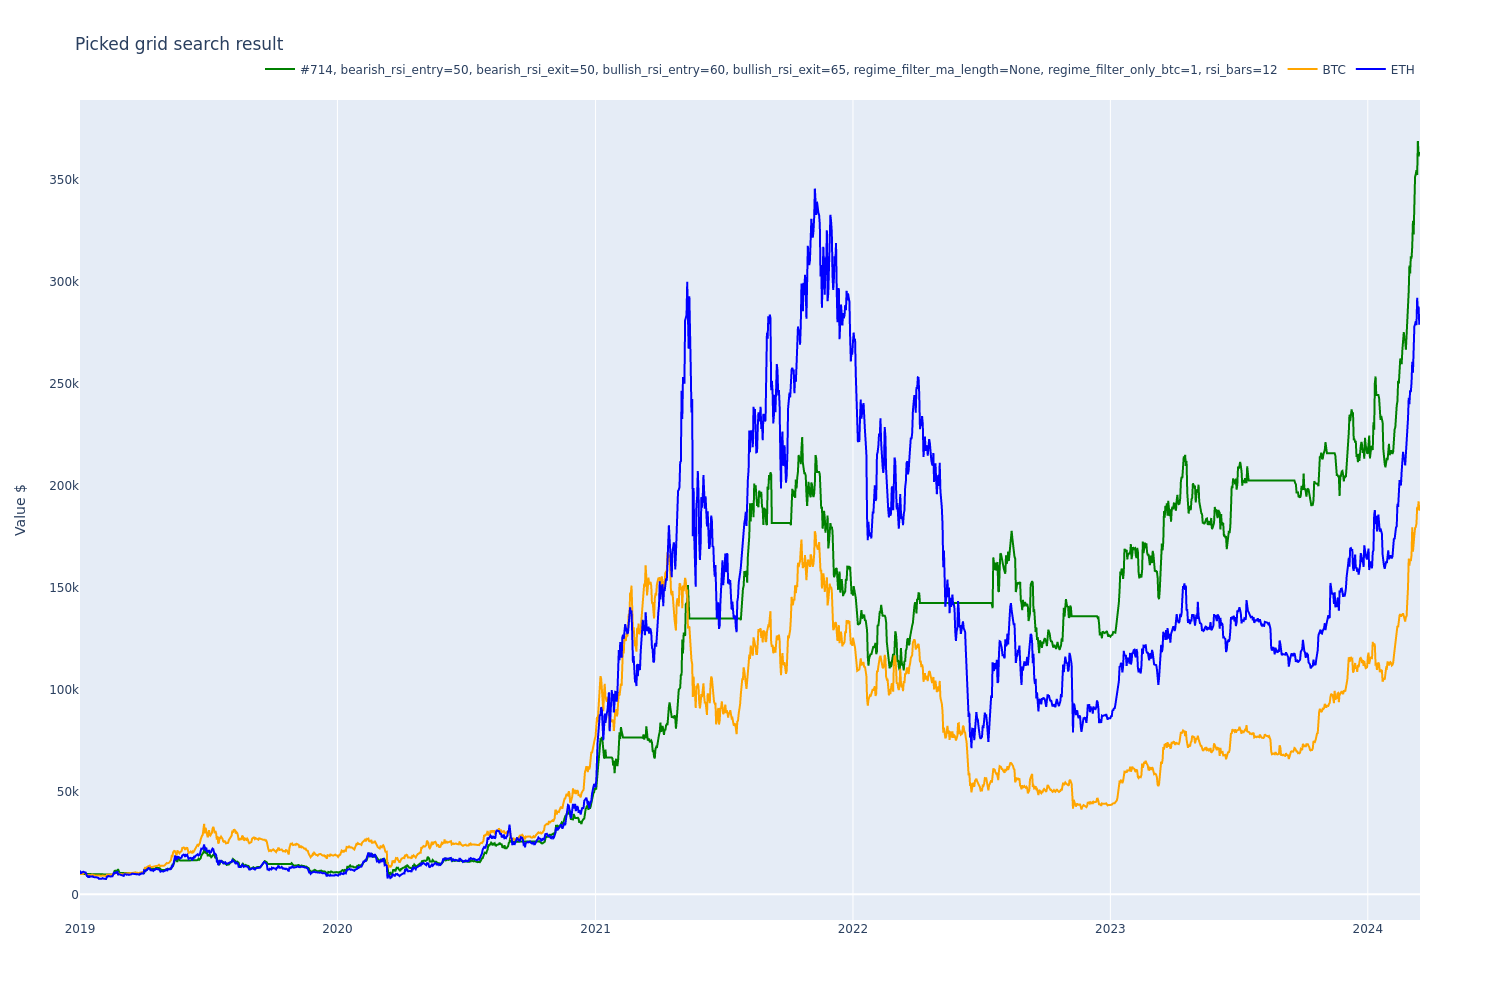

In [110]:
fig = visualise_single_grid_search_result_benchmark(best_results.cagr[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

In [111]:
print("By Sharpe")
render_grid_search_result_table(best_results.sharpe)



By Sharpe


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_length 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 50 
 50 
 50 
 55 
 nan 
 0 
 8 
 150 
 454 
 74.00% 
 87.47% 
 -71.00% 
 1.320000 
 2.000000 
 2.24% 
 -0.50% 
 
 
 60 
 nan 
 1 
 8 
 119 
 394 
 76.00% 
 80.17% 
 -71.00% 
 1.260000 
 1.900000 
 3.08% 
 0.68% 
 
 
 55 
 50 
 nan 
 0 
 12 
 90 
 354 
 63.00% 
 76.65% 
 -62.00% 
 1.270000 
 1.860000 
 0.79% 
 -2.42% 
 
 
 1 
 30 
 29 
 193 
 60.00% 
 93.20% 
 -54.00% 
 1.440000 
 2.150000 
 3.78% 
 1.67% 
 
 
 55 
 nan 
 1 
 12 
 138 
 442 
 61.00% 
 89.56% 
 -55.00% 
 1.410000 
 2.120000 
 0.99% 
 -1.81% 
 
 
 75 
 nan 
 0 
 30 
 10 
 274 
 96.00% 
 83.67% 
 -76.00% 
 1.220000 
 1.800000 
 28.16% 
 14.46% 
 
 
 80 
 nan 
 1 
 30 
 3 
 nan 
 nan% 
 nan% 
 nan% 
 nan 
 nan 
 nan% 
 nan% 
 
 
 60 
 50 
 nan 
 1 
 30 
 24 
 183 
 49.00% 
 78.71% 
 -55.00% 
 1.380000 
 2.050000 
 1.42% 
 -0.17% 
 
 
 55 
 nan 
 0 
 30 
 29 
 156 
 50.00% 
 92.82% 
 -55.00% 
 1.450000 
 2.120000 
 3.58% 
 0.08% 
 
 
 1 
 21 
 50 
 196 
 51.00% 
 84.99% 
 -56.00% 
 1.370000 
 2.030000 
 3.14% 
 -2.89% 
 
 
 65 
 nan 
 1 
 12 
 82 
 362 
 73.00% 
 99.51% 
 -60.00% 
 1.470000 
 2.250000 
 4.61% 
 1.91% 
 
 
 80 
 nan 
 1 
 30 
 4 
 nan 
 nan% 
 nan% 
 nan% 
 nan 
 nan 
 nan% 
 nan% 
 
 
 65 
 50 
 nan 
 0 
 12 
 45 
 188 
 53.00% 
 88.92% 
 -62.00% 
 1.390000 
 2.060000 
 5.14% 
 0.15% 
 
 
 1 
 8 
 80 
 308 
 53.00% 
 72.99% 
 -40.00% 
 1.310000 
 2.010000 
 1.71% 
 -1.26% 
 
 
 21 
 27 
 165 
 45.00% 
 67.77% 
 -51.00% 
 1.290000 
 1.910000 
 1.94% 
 2.45% 
 
 
 55 
 nan 
 0 
 21 
 36 
 163 
 42.00% 
 65.59% 
 -55.00% 
 1.240000 
 1.830000 
 2.90% 
 -0.98% 
 
 
 70 
 nan 
 1 
 8 
 107 
 345 
 59.00% 
 76.73% 
 -55.00% 
 1.330000 
 2.070000 
 2.78% 
 1.85% 
 
 
 70 
 55 
 nan 
 1 
 21 
 23 
 91 
 28.00% 
 57.86% 
 -33.00% 
 1.300000 
 2.040000 
 3.02% 
 -0.46% 
 
 
 75 
 65 
 nan 
 1 
 12 
 35 
 96 
 19.00% 
 44.84% 
 -27.00% 
 1.280000 
 2.140000 
 5.24% 
 -1.23% 
 
 
 80 
 75 
 nan 
 0 
 8 
 51 
 131 
 17.00% 
 45.37% 
 -26.00% 
 1.350000 
 2.410000 
 3.01% 
 0.24%

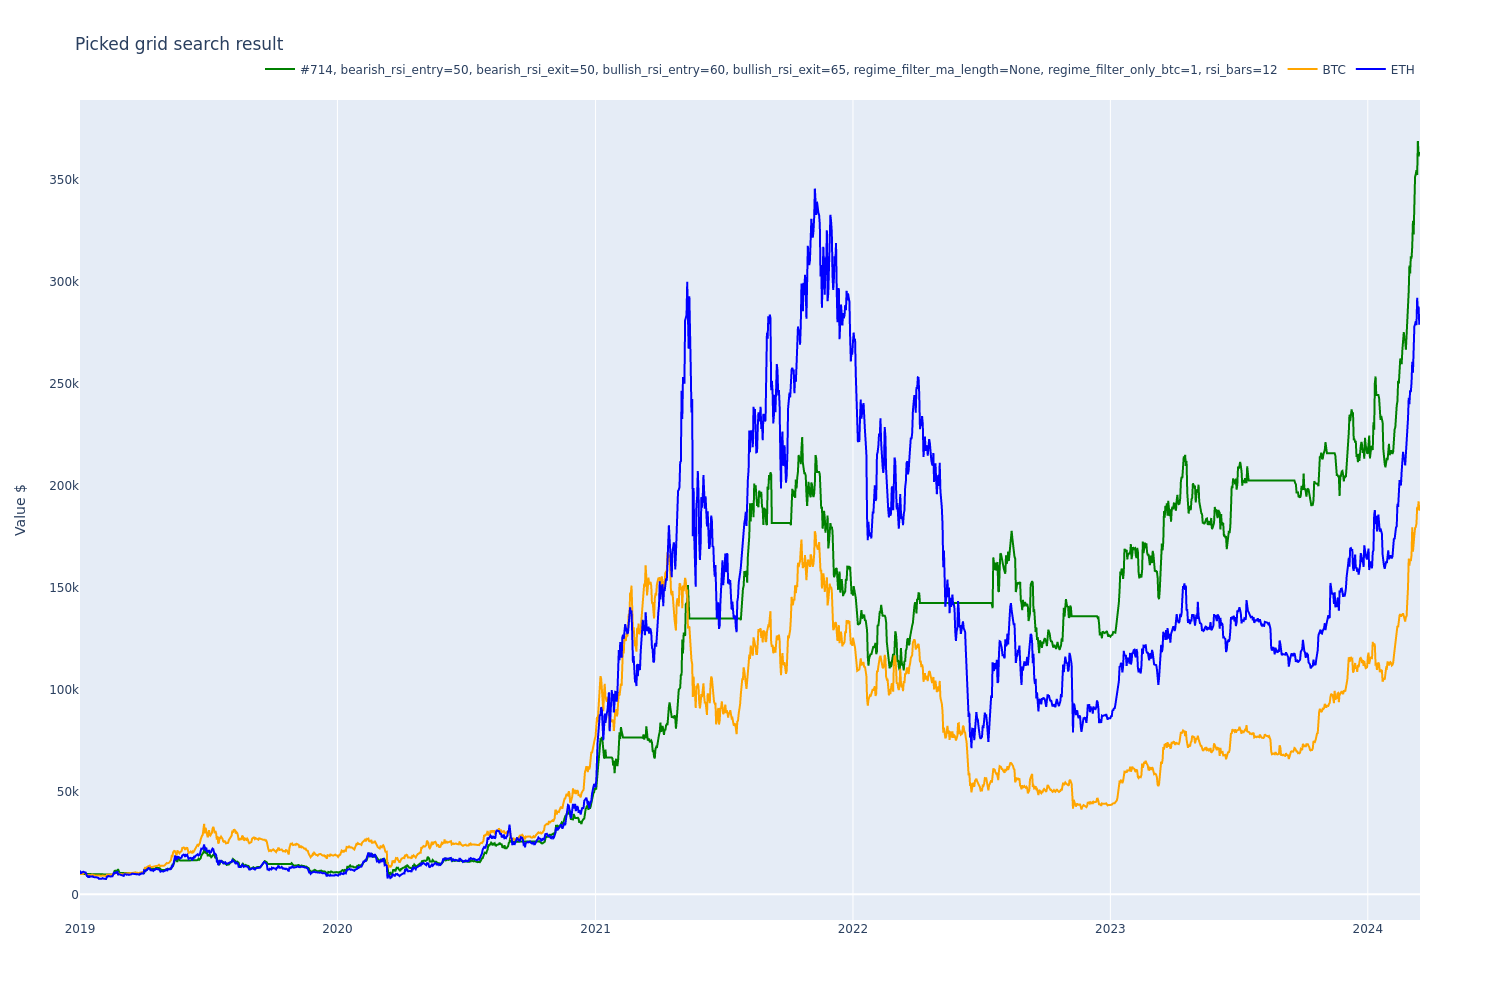

In [112]:
fig = visualise_single_grid_search_result_benchmark(best_results.sharpe[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

## Best result - BTC regime filter

In [113]:
filtered_results = [r for r in grid_search_results if r.combination.get_parameter("regime_filter_only_btc") == 1]

best_results = find_best_grid_search_results(filtered_results)
print("By CAGR")
render_grid_search_result_table(best_results.cagr)


By CAGR


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_length 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 50 
 65 
 50 
 55 
 200 
 1 
 8 
 106 
 374 
 78.00% 
 108.11% 
 -68.00% 
 1.470000 
 2.240000 
 3.88% 
 1.26% 
 
 
 67 
 70 
 55 
 200 
 1 
 8 
 78 
 281 
 76.00% 
 103.52% 
 -75.00% 
 1.420000 
 2.140000 
 4.77% 
 2.19% 
 
 
 70 
 60 
 50 
 100 
 1 
 21 
 28 
 261 
 76.00% 
 105.42% 
 -56.00% 
 1.460000 
 2.210000 
 6.95% 
 1.47% 
 
 
 55 
 50 
 50 
 80 
 150 
 1 
 30 
 15 
 217 
 77.00% 
 102.99% 
 -60.00% 
 1.450000 
 2.100000 
 8.30% 
 3.31% 
 
 
 55 
 80 
 150 
 1 
 30 
 15 
 199 
 79.00% 
 112.50% 
 -61.00% 
 1.500000 
 2.200000 
 6.69% 
 3.84% 
 
 
 60 
 75 
 100 
 1 
 30 
 24 
 201 
 70.00% 
 109.37% 
 -54.00% 
 1.520000 
 2.240000 
 11.46% 
 9.89% 
 
 
 80 
 100 
 1 
 30 
 17 
 210 
 71.00% 
 121.27% 
 -57.00% 
 1.600000 
 2.350000 
 12.21% 
 4.17% 
 
 
 65 
 80 
 100 
 1 
 30 
 15 
 166 
 67.00% 
 106.84% 
 -51.00% 
 1.550000 
 2.310000 
 11.74% 
 7.21% 
 
 
 60 
 50 
 60 
 65 
 150 
 1 
 12 
 83 
 328 
 60.00% 
 109.76% 
 -48.00% 
 1.680000 
 2.710000 
 3.86% 
 1.09% 
 
 
 75 
 100 
 1 
 30 
 22 
 191 
 67.00% 
 111.01% 
 -54.00% 
 1.550000 
 2.280000 
 12.56% 
 11.89% 
 
 
 80 
 100 
 1 
 30 
 15 
 200 
 69.00% 
 123.05% 
 -57.00% 
 1.630000 
 2.400000 
 14.06% 
 6.45% 
 
 
 60 
 60 
 50 
 150 
 1 
 30 
 24 
 185 
 51.00% 
 106.49% 
 -62.00% 
 1.570000 
 2.330000 
 3.43% 
 -0.70% 
 
 
 55 
 150 
 1 
 30 
 28 
 163 
 50.00% 
 112.72% 
 -55.00% 
 1.640000 
 2.450000 
 4.87% 
 0.32% 
 
 
 70 
 80 
 150 
 1 
 30 
 8 
 79 
 81.00% 
 122.48% 
 -68.00% 
 1.520000 
 2.240000 
 29.71% 
 31.27% 
 
 
 65 
 50 
 60 
 75 
 100 
 1 
 30 
 21 
 189 
 67.00% 
 119.19% 
 -54.00% 
 1.610000 
 2.400000 
 14.03% 
 12.98% 
 
 
 80 
 100 
 1 
 30 
 14 
 198 
 69.00% 
 131.70% 
 -57.00% 
 1.700000 
 2.510000 
 16.37% 
 7.14% 
 
 
 150 
 1 
 30 
 13 
 233 
 76.00% 
 113.77% 
 -62.00% 
 1.530000 
 2.240000 
 14.52% 
 7.15% 
 
 
 60 
 70 
 80 
 150 
 1 
 30 
 6 
 73 
 68.00% 
 117.82% 
 -68.00% 
 1.570000 
 2.330000 
 37.46% 
 41.79% 
 
 
 67 
 70 
 50 
 55 
 200 
 1 
 8 
 126 
 365 
 63.00% 
 114.75% 
 -54.00% 
 1.660000 
 2.570000 
 3.15% 
 -0.77% 
 
 
 75 
 50 
 55 
 200 
 1 
 8 
 115 
 371 
 68.00% 
 116.05% 
 -54.00% 
 1.620000 
 2.510000 
 3.42% 
 -0.22%

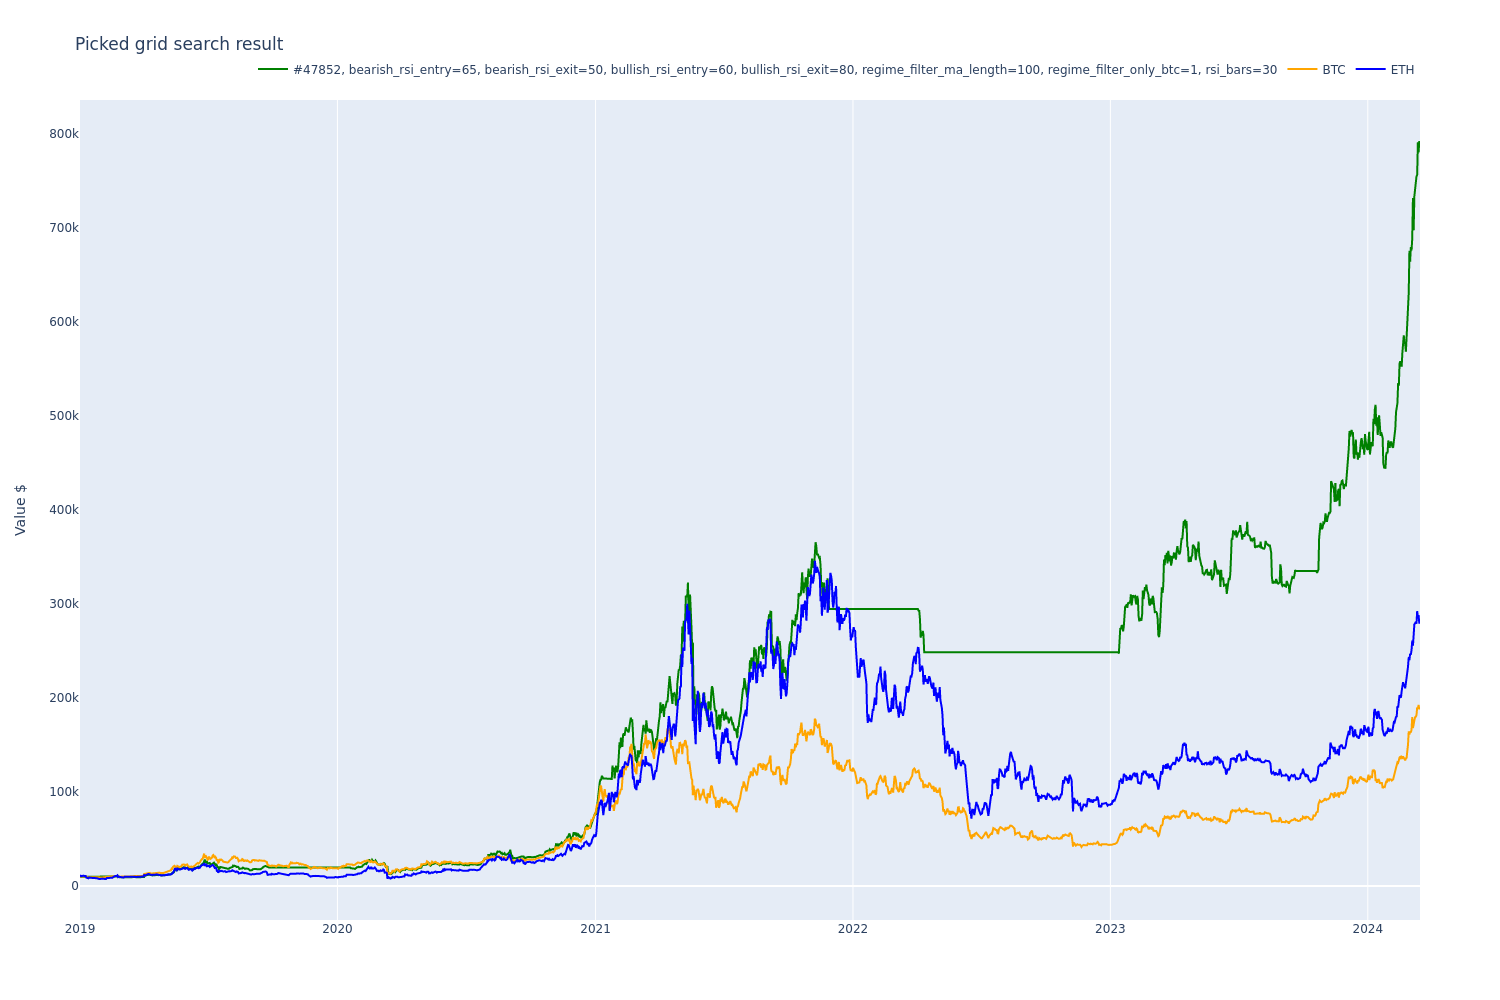

In [114]:
fig = visualise_single_grid_search_result_benchmark(best_results.cagr[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

In [115]:
print("By Sharpe")
render_grid_search_result_table(best_results.sharpe)



By Sharpe


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_length 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 55.000000 
 50 
 60 
 65 
 150 
 1 
 12 
 91 
 345 
 62.00% 
 103.33% 
 -51.00% 
 1.600000 
 2.570000 
 3.48% 
 0.79% 
 
 
 200 
 1 
 12 
 91 
 345 
 62.00% 
 102.44% 
 -51.00% 
 1.590000 
 2.560000 
 3.48% 
 0.79% 
 
 
 65 
 80 
 100 
 1 
 30 
 15 
 166 
 67.00% 
 106.84% 
 -51.00% 
 1.550000 
 2.310000 
 11.74% 
 7.21% 
 
 
 70 
 75 
 150 
 1 
 12 
 67 
 259 
 64.00% 
 106.72% 
 -47.00% 
 1.570000 
 2.480000 
 4.87% 
 1.22% 
 
 
 60.000000 
 50 
 60 
 65 
 150 
 1 
 12 
 83 
 328 
 60.00% 
 109.76% 
 -48.00% 
 1.680000 
 2.710000 
 3.86% 
 1.09% 
 
 
 200 
 1 
 12 
 84 
 330 
 60.00% 
 108.02% 
 -48.00% 
 1.660000 
 2.680000 
 3.79% 
 1.02% 
 
 
 80 
 100 
 1 
 30 
 15 
 200 
 69.00% 
 123.05% 
 -57.00% 
 1.630000 
 2.400000 
 14.06% 
 6.45% 
 
 
 70 
 75 
 150 
 1 
 12 
 60 
 247 
 63.00% 
 106.76% 
 -47.00% 
 1.580000 
 2.510000 
 5.11% 
 2.33% 
 
 
 60 
 60 
 55 
 150 
 1 
 30 
 28 
 163 
 50.00% 
 112.72% 
 -55.00% 
 1.640000 
 2.450000 
 4.87% 
 0.32% 
 
 
 200 
 1 
 30 
 30 
 176 
 50.00% 
 106.02% 
 -55.00% 
 1.560000 
 2.300000 
 4.05% 
 -0.50% 
 
 
 65.000000 
 50 
 60 
 75 
 100 
 1 
 30 
 21 
 189 
 67.00% 
 119.19% 
 -54.00% 
 1.610000 
 2.400000 
 14.03% 
 12.98% 
 
 
 80 
 100 
 1 
 30 
 14 
 198 
 69.00% 
 131.70% 
 -57.00% 
 1.700000 
 2.510000 
 16.37% 
 7.14% 
 
 
 54 
 50 
 55 
 50 
 1 
 8 
 108 
 299 
 54.00% 
 102.31% 
 -41.00% 
 1.670000 
 2.750000 
 3.49% 
 -0.65% 
 
 
 55 
 50 
 50 
 1 
 8 
 107 
 355 
 57.00% 
 110.11% 
 -37.00% 
 1.690000 
 2.700000 
 2.16% 
 -1.52% 
 
 
 67 
 75 
 50 
 100 
 1 
 12 
 37 
 121 
 39.00% 
 94.83% 
 -34.00% 
 1.650000 
 2.660000 
 6.78% 
 0.90% 
 
 
 80 
 65 
 50 
 1 
 8 
 51 
 142 
 26.00% 
 71.67% 
 -34.00% 
 1.620000 
 2.790000 
 4.87% 
 -0.38% 
 
 
 70 
 80 
 65 
 200 
 1 
 8 
 61 
 174 
 30.00% 
 82.43% 
 -34.00% 
 1.770000 
 3.060000 
 4.67% 
 0.55% 
 
 
 67.000000 
 67 
 80 
 65 
 150 
 1 
 8 
 63 
 168 
 28.00% 
 80.23% 
 -34.00% 
 1.730000 
 3.030000 
 4.06% 
 -1.05% 
 
 
 70 
 80 
 65 
 200 
 1 
 8 
 61 
 163 
 29.00% 
 78.10% 
 -34.00% 
 1.740000 
 3.000000 
 4.44% 
 -0.38% 
 
 
 nan 
 50 
 50 
 60 
 50 
 1 
 8 
 91 
 252 
 43.00% 
 89.30% 
 -44.00% 
 1.710000 
 2.890000 
 3.80% 
 0.52%

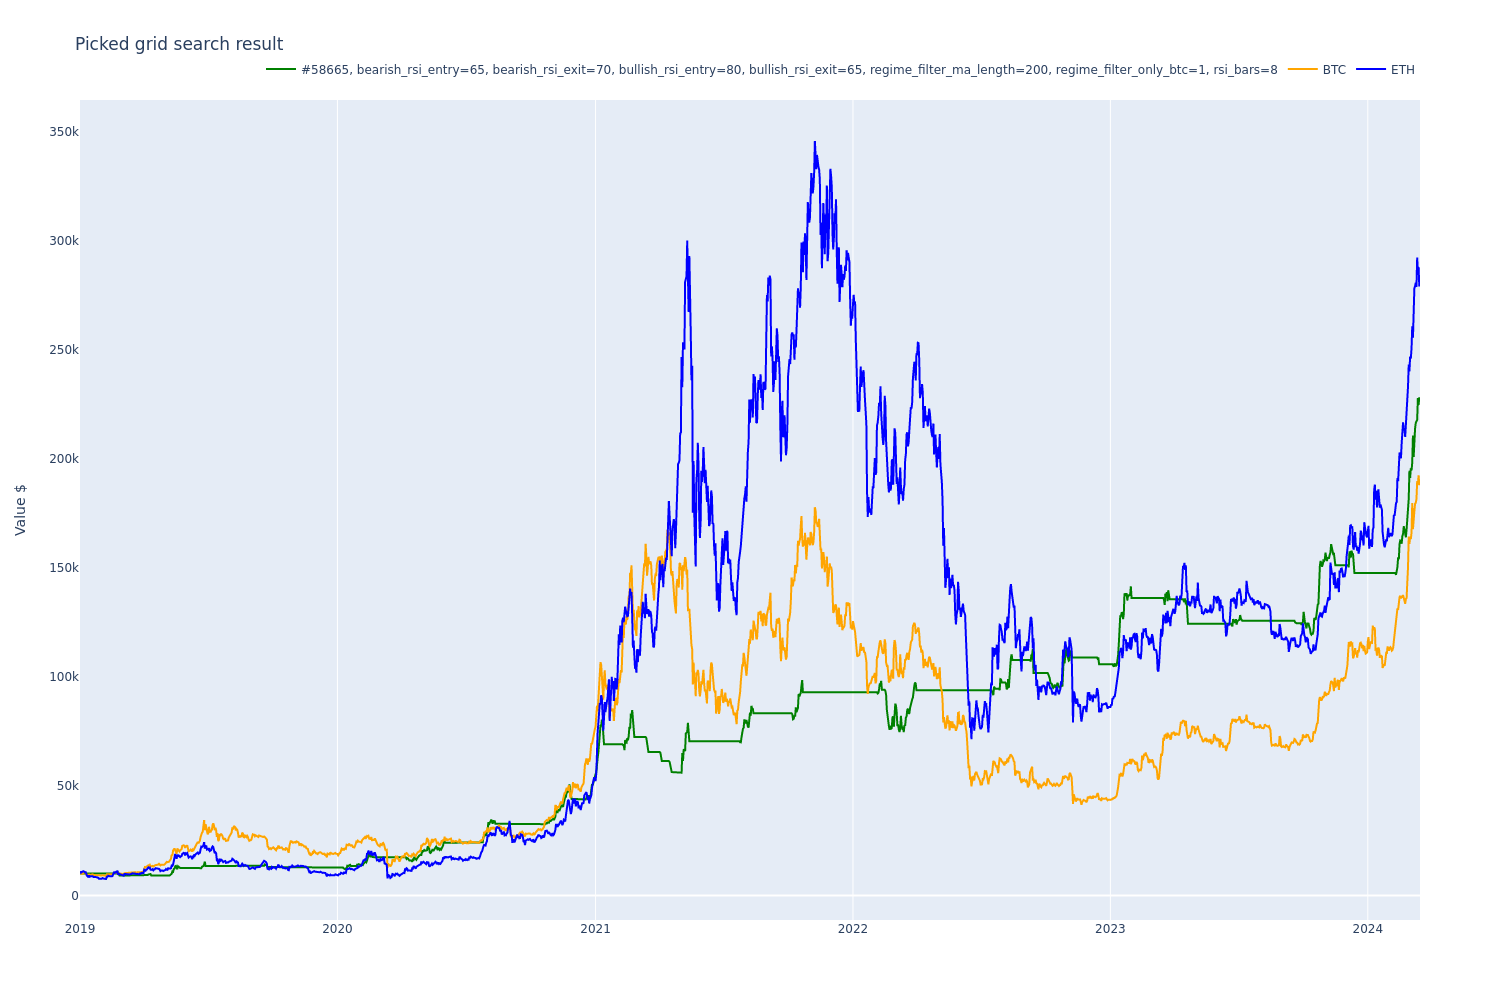

In [116]:
fig = visualise_single_grid_search_result_benchmark(best_results.sharpe[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

## Best result - per-pair regime filter

In [117]:
filtered_results = [r for r in grid_search_results if r.combination.get_parameter("regime_filter_only_btc") == 0]

best_results = find_best_grid_search_results(filtered_results)
print("By CAGR")
render_grid_search_result_table(best_results.cagr)

By CAGR


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_length 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 50 
 50 
 60 
 65 
 nan 
 0 
 12 
 82 
 362 
 73.00% 
 99.51% 
 -60.00% 
 1.470000 
 2.250000 
 4.61% 
 1.91% 
 
 
 54 
 55 
 50 
 100.000000 
 0 
 30 
 36 
 275 
 76.00% 
 102.59% 
 -57.00% 
 1.440000 
 2.160000 
 2.73% 
 1.55% 
 
 
 60 
 50 
 50 
 50.000000 
 0 
 21 
 32 
 320 
 93.00% 
 104.15% 
 -67.00% 
 1.360000 
 1.980000 
 1.12% 
 -0.70% 
 
 
 55 
 100.000000 
 0 
 8 
 137 
 433 
 75.00% 
 101.01% 
 -68.00% 
 1.440000 
 2.200000 
 2.70% 
 -0.15% 
 
 
 150.000000 
 0 
 8 
 139 
 434 
 75.00% 
 106.86% 
 -61.00% 
 1.490000 
 2.280000 
 2.74% 
 -0.09% 
 
 
 60 
 55 
 100.000000 
 0 
 21 
 51 
 262 
 68.00% 
 104.88% 
 -55.00% 
 1.470000 
 2.200000 
 4.22% 
 0.89% 
 
 
 30 
 33 
 217 
 68.00% 
 102.49% 
 -60.00% 
 1.450000 
 2.130000 
 4.18% 
 0.55% 
 
 
 55 
 50 
 55 
 80 
 200.000000 
 0 
 30 
 15 
 220 
 79.00% 
 107.55% 
 -62.00% 
 1.450000 
 2.120000 
 4.07% 
 3.84% 
 
 
 60 
 80 
 150.000000 
 0 
 30 
 14 
 267 
 78.00% 
 114.90% 
 -58.00% 
 1.510000 
 2.220000 
 7.06% 
 4.60% 
 
 
 54 
 55 
 80 
 150.000000 
 0 
 30 
 17 
 230 
 80.00% 
 110.72% 
 -65.00% 
 1.460000 
 2.140000 
 3.55% 
 0.43% 
 
 
 60 
 60 
 55 
 50.000000 
 0 
 30 
 27 
 171 
 52.00% 
 112.07% 
 -55.00% 
 1.590000 
 2.350000 
 3.95% 
 -0.12% 
 
 
 65 
 65 
 50 
 200.000000 
 0 
 12 
 51 
 231 
 65.00% 
 109.91% 
 -51.00% 
 1.580000 
 2.510000 
 5.31% 
 1.59% 
 
 
 70 
 55 
 55 
 150.000000 
 0 
 12 
 113 
 411 
 71.00% 
 117.19% 
 -47.00% 
 1.640000 
 2.630000 
 1.72% 
 -1.60% 
 
 
 65 
 50 
 100.000000 
 0 
 12 
 44 
 234 
 69.00% 
 105.57% 
 -55.00% 
 1.470000 
 2.220000 
 6.49% 
 2.85% 
 
 
 150.000000 
 0 
 12 
 43 
 224 
 69.00% 
 112.77% 
 -55.00% 
 1.520000 
 2.310000 
 6.76% 
 0.58% 
 
 
 200.000000 
 0 
 12 
 45 
 219 
 66.00% 
 108.83% 
 -53.00% 
 1.540000 
 2.420000 
 6.27% 
 0.90% 
 
 
 60 
 60 
 70 
 80 
 150.000000 
 0 
 30 
 7 
 91 
 81.00% 
 119.21% 
 -68.00% 
 1.490000 
 2.170000 
 27.03% 
 25.04% 
 
 
 65 
 60 
 70 
 80 
 150.000000 
 0 
 30 
 6 
 89 
 81.00% 
 119.94% 
 -68.00% 
 1.490000 
 2.180000 
 31.83% 
 33.01% 
 
 
 67 
 67 
 50 
 55 
 150.000000 
 0 
 8 
 130 
 381 
 65.00% 
 115.71% 
 -54.00% 
 1.580000 
 2.440000 
 2.81% 
 -1.04% 
 
 
 75 
 50 
 55 
 150.000000 
 0 
 8 
 115 
 380 
 73.00% 
 114.17% 
 -61.00% 
 1.560000 
 2.400000 
 3.38% 
 -0.22%

In [118]:

fig = visualise_single_grid_search_result_benchmark(best_results.cagr[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()

In [119]:
print("By Sharpe")
render_grid_search_result_table(best_results.sharpe)


By Sharpe


Positions 
 Trades 
 Time in market 
 CAGR 
 Max drawdown 
 Sharpe 
 Sortino 
 Average position 
 Median position 
 
 
 bearish_rsi_entry 
 bearish_rsi_exit 
 bullish_rsi_entry 
 bullish_rsi_exit 
 regime_filter_ma_length 
 regime_filter_only_btc 
 rsi_bars 
   
   
   
   
   
   
   
   
   
 
 
 
 
 55 
 60 
 60 
 50 
 200 
 0 
 12 
 75 
 296 
 62.00% 
 96.94% 
 -49.00% 
 1.550000 
 2.430000 
 2.14% 
 -1.00% 
 
 
 55 
 50 
 0 
 30 
 27 
 171 
 52.00% 
 112.07% 
 -55.00% 
 1.590000 
 2.350000 
 3.95% 
 -0.12% 
 
 
 65 
 60 
 50 
 200 
 0 
 12 
 63 
 289 
 66.00% 
 106.53% 
 -47.00% 
 1.600000 
 2.520000 
 2.95% 
 -0.03% 
 
 
 65 
 50 
 200 
 0 
 12 
 51 
 231 
 65.00% 
 109.91% 
 -51.00% 
 1.580000 
 2.510000 
 5.31% 
 1.59% 
 
 
 67 
 60 
 50 
 200 
 0 
 12 
 59 
 285 
 66.00% 
 114.80% 
 -49.00% 
 1.650000 
 2.610000 
 3.40% 
 0.83% 
 
 
 70 
 55 
 55 
 150 
 0 
 12 
 113 
 411 
 71.00% 
 117.19% 
 -47.00% 
 1.640000 
 2.630000 
 1.72% 
 -1.60% 
 
 
 60 
 50 
 200 
 0 
 12 
 56 
 275 
 67.00% 
 112.07% 
 -49.00% 
 1.610000 
 2.530000 
 3.77% 
 0.16% 
 
 
 75 
 50 
 150 
 0 
 12 
 32 
 154 
 57.00% 
 102.33% 
 -42.00% 
 1.560000 
 2.500000 
 8.20% 
 2.11% 
 
 
 60 
 50 
 60 
 65 
 200 
 0 
 12 
 85 
 332 
 60.00% 
 99.80% 
 -55.00% 
 1.570000 
 2.500000 
 3.70% 
 1.09% 
 
 
 65 
 55 
 55 
 100 
 0 
 12 
 119 
 430 
 68.00% 
 110.17% 
 -53.00% 
 1.620000 
 2.590000 
 1.32% 
 -1.39% 
 
 
 65 
 67 
 80 
 65 
 50 
 0 
 8 
 47 
 123 
 26.00% 
 69.62% 
 -34.00% 
 1.630000 
 2.780000 
 5.47% 
 1.79% 
 
 
 70 
 80 
 60 
 150 
 0 
 8 
 54 
 165 
 36.00% 
 81.32% 
 -41.00% 
 1.660000 
 2.800000 
 4.57% 
 0.82% 
 
 
 65 
 150 
 0 
 8 
 55 
 163 
 34.00% 
 81.02% 
 -39.00% 
 1.690000 
 2.870000 
 4.74% 
 0.55% 
 
 
 67 
 67 
 80 
 60 
 150 
 0 
 8 
 61 
 166 
 27.00% 
 78.14% 
 -35.00% 
 1.700000 
 2.990000 
 3.99% 
 -0.90% 
 
 
 65 
 100 
 0 
 8 
 57 
 151 
 26.00% 
 78.27% 
 -34.00% 
 1.720000 
 3.050000 
 4.87% 
 -0.38% 
 
 
 150 
 0 
 8 
 61 
 162 
 26.00% 
 80.03% 
 -34.00% 
 1.760000 
 3.140000 
 4.31% 
 -0.87% 
 
 
 70 
 67 
 80 
 60 
 150 
 0 
 8 
 52 
 146 
 26.00% 
 76.33% 
 -35.00% 
 1.680000 
 2.960000 
 4.50% 
 0.75% 
 
 
 65 
 150 
 0 
 8 
 52 
 142 
 24.00% 
 78.20% 
 -34.00% 
 1.740000 
 3.120000 
 4.87% 
 0.75% 
 
 
 80 
 75 
 55 
 55 
 200 
 0 
 12 
 102 
 329 
 49.00% 
 97.45% 
 -44.00% 
 1.670000 
 2.710000 
 1.66% 
 -1.75% 
 
 
 60 
 50 
 200 
 0 
 12 
 47 
 205 
 50.00% 
 104.13% 
 -49.00% 
 1.710000 
 2.730000 
 3.88% 
 -0.23%

In [120]:

fig = visualise_single_grid_search_result_benchmark(best_results.sharpe[0], strategy_universe, initial_cash=HighFeeStopLossStrategyParameters.initial_cash)
fig.show()